In [35]:
!pip install autograd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 365.9 kB/s eta 0:00:001m846.9 kB/s eta 0:00:01


In [289]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Matrix, Function, simplify, exp, hessian, solve, init_printing
import numpy.linalg as lin
import autograd.numpy as np 
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize
import pymc3 as pm
init_printing()

# Logistic Regression - Param Fit and Uncertainty

### Equations

In [309]:
def logodds(x, beta):
    lo = (beta[0] + np.dot(1 * beta[1::], x))
    return lo

def p(logodds):
    return 1 / (1 + np.exp(-1 * logodds))

def logloss(x, y, beta_params):
    lo = logodds(x, beta_params)
    ### If lo = 20+ and y = 0 get -20+; if lo = -20- and y =1 get -20-
    if lo > 20:
        return - lo * (1 - y)
    elif lo < -20:
        return lo * y
    else:
        return (np.log(p(lo)) * y + np.log(1 - p(lo)) * (1 - y))

def negative_log_likelihood(beta_params, x_train, y_train):
    return -1 *np.sum([logloss(xi, yi, beta_params) for xi, yi in zip(x_train, y_train)] )

### Simulate Data

In [270]:
n = 1000
beta_true = np.array([.1, -.5, 2.3])
x_train = np.random.uniform(low = -5, high = 5, size = (n,2))
p_train = [p(logodds(xi, beta = beta_true)) for xi in x_train]
y_train = np.random.binomial(n = 1, p = p_train)
negative_log_likelihood(beta_true, x_train, y_train)

In [276]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit

In [286]:
log_reg = sm.Logit( y_train, sm.tools.tools.add_constant(x_train)).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.150783
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Wed, 22 Mar 2023   Pseudo R-squ.:                  0.7824
Time:                        13:46:31   Log-Likelihood:                -150.78
converged:                       True   LL-Null:                       -692.91
Covariance Type:            nonrobust   LLR p-value:                3.627e-236
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2670      0.151      1.764      0.078      -0.030       0.564
x1            -0.4300      0.

### Parameter Estimates from MLE and Fisher information (inv Hessian at MLE) std error

#### MLE

In [312]:
b0 = [0,0,0]
jacobian_ = jacobian(negative_log_likelihood)
hessian_ = hessian(negative_log_likelihood)

result = minimize(negative_log_likelihood, b0, args=(x_train, y_train), jac = jacobian_, method='Nelder-Mead')
print(result.x)

[ 0.26703571 -0.42994189  2.25097322]


#### Std Error

In [313]:
hessinv = np.linalg.inv(hessian_(result.x, x_train, y_train))
print(np.sqrt(np.diag(hessinv)))

[0.15136638 0.06373159 0.18026799]


In [311]:
beta0_plt = result.x[0]
beta1_plt = np.linspace(-2, 3, 50)
beta2_plt = np.linspace(0, 5, 50)
like_plt = np.zeros((len(beta1_plt), len(beta2_plt)))
for i,b1 in enumerate(beta1_plt):
    for j,b2 in enumerate(beta2_plt):
        like_plt[i,j] = negative_log_likelihood([beta0_plt, b1, b2], x_train, y_train)

<IPython.core.display.Javascript object>


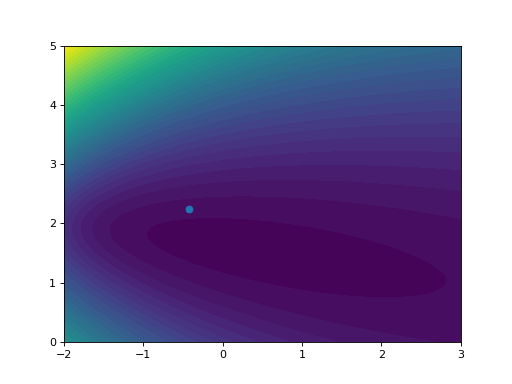

In [314]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.contourf(beta1_plt, beta2_plt,like_plt, levels = 50)
ax.scatter(result.x[1],result.x[2])

### Just showing 1/sqrt(n) MLE estimate stddev dependence


In [318]:
i

In [317]:
n_obs = [200,500,1000,2000]
beta_true = np.array([.1, -.5, 2.3])
b0 = [0,0,0]
hessian_ = hessian(negative_log_likelihood)
fits = {}
for n in n_obs:
    print(n)
    fits[n] = {'mle':[], 'std_err' : []}
    for i in range(40):
        x_train = np.random.uniform(low = -5, high = 5, size = (n,2))
        p_train = [p(logodds(xi, beta = beta_true)) for xi in x_train]
        y_train = np.random.binomial(n = 1, p = p_train)
        result = minimize(negative_log_likelihood, b0, args=(x_train, y_train), jac = jacobian_, method='Nelder-Mead')
        fits[n]['mle'].append(result.x)
        hessinv = np.linalg.inv(hessian_(result.x, x_train, y_train))
        fits[n]['std_err'].append(np.sqrt(np.diag(hessinv)))

200
500
1000
2000


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


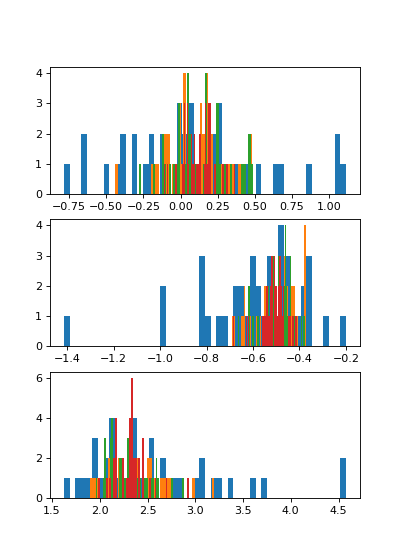

In [332]:
n_obs = [200,500,1000,2000]
fig, ax = plt.subplots((3), figsize = (5,7))
for n in n_obs:   
    for b in range(3):
        ax[b].hist(np.array(fits[n]['mle'])[:,b], bins = 50)

### Bayesian estimation

p(Beta | y) ~ p(y | Beta) * p(Beta)

In [262]:
def bayesian_log_regression(x_train, y_train):
    with pm.Model() as log_regression_model:
        betas = []
        # priors
        for n in range(3):
            betas.append(pm.Normal(f"β{n}", mu=0, sigma=5))
        # logistic regression model
        μ = betas[0] + betas[1] * x_train[:,0] + betas[2] * x_train[:,1]
        p = pm.Deterministic("p", pm.math.invlogit(μ))
        # likelihood
        pm.Bernoulli("y", p=p, observed=y_train)
    return log_regression_model

def get_95_hdi(arr):
    return np.quantile(arr, .975) - np.quantile(arr, .025)

fits_b = {}
for n in n_obs:
    print(n)
    fits_b[n] = {'post_mean':[], 'post_95_hdi' : []}
    for i in range(5):
        x_train = np.random.uniform(low = -5, high = 5, size = (n,2))
        p_train = [p(logodds(xi, beta = beta_true)) for xi in x_train]
        y_train = np.random.binomial(n = 1, p = p_train)
        log_regression_model = bayesian_log_regression()
    with log_regression_model:
        trace = pm.sample(
            4000, tune=4000, target_accept=0.95,);
        fits_b[n]['post_mean'].append([np.mean(trace[f'β{j}']) for j in range(3)])
        fits_b[n]['post_95_hdi'].append([get_95_hdi(trace[f'β{j}']) for j in range(3)])

/home/christine/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β2, β1, β0]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 20 seconds.


<IPython.core.display.Javascript object>


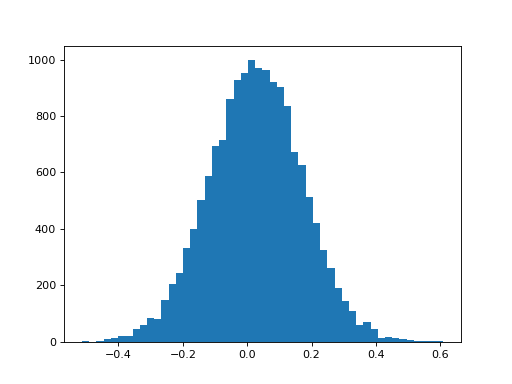

0.026262738426435703
-0.2441850739105248
2.068255663616521


In [265]:
fig, ax = plt.subplots();
ax.hist(trace['β0'], bins = 50);
for n in range(3):
    print(np.mean(trace[f'β{n}']))